# Hello Fulcra: Connecting and Retrieving Your Data

> This notebook is an introduction to accessing your data using the Fulcra
Data API.

This uses the `fulcra-api-python` module, which is available on GitHub
at [https://github.com/fulcradynamics/fulcra-api-python](https://github.com/fulcradynamics/fulcra-api-python).


In [3]:
%pip install -qU fulcra-api


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from fulcra_api.core import FulcraAPI
import seaborn as sns

fulcra = FulcraAPI()

## Logging in to Fulcra

To make calls to the API, call `authorize()` first.  You authorize the `FulcraAPI`
instance using your browser.  The `authorize()` function will generate a link below
that you should click to log in to Fulcra.  (Depending on the notebook front-end
you're using, this tab may open automatically. On Colaboratory and other hosted
solutions, pop-up blockers usually prevent this from happening.)

Once you've logged in, close the tab; you should see "Authorization succeeded"
displayed in the notebook output.  


In [ ]:
fulcra.authorize()

## Retrieving Time Series Data

Once your `FulcraAPI` instance is authorized, you can now use it
to make API calls.

The `time_series_grouped` function returns a Pandas dataframe.

In [ ]:
df = fulcra.time_series_grouped(
    sample_rate = 86400,
    start_time = "2023-06-01 04:00:00.000Z",
    end_time = "2023-08-30 04:00:00.000Z",
    metrics = [
        "StepCount",
    ]
)
df

,step_count
time,
2023-06-01 04:00:00+00:00,21342.739935
2023-06-02 04:00:00+00:00,11364.499298
2023-06-03 04:00:00+00:00,11396.816792
2023-06-04 04:00:00+00:00,5797.707317
2023-06-05 04:00:00+00:00,11709.291613
...,...
2023-08-25 04:00:00+00:00,8413.802485
2023-08-26 04:00:00+00:00,7554.051794
2023-08-27 04:00:00+00:00,10220.88192


<Axes: xlabel='time'>

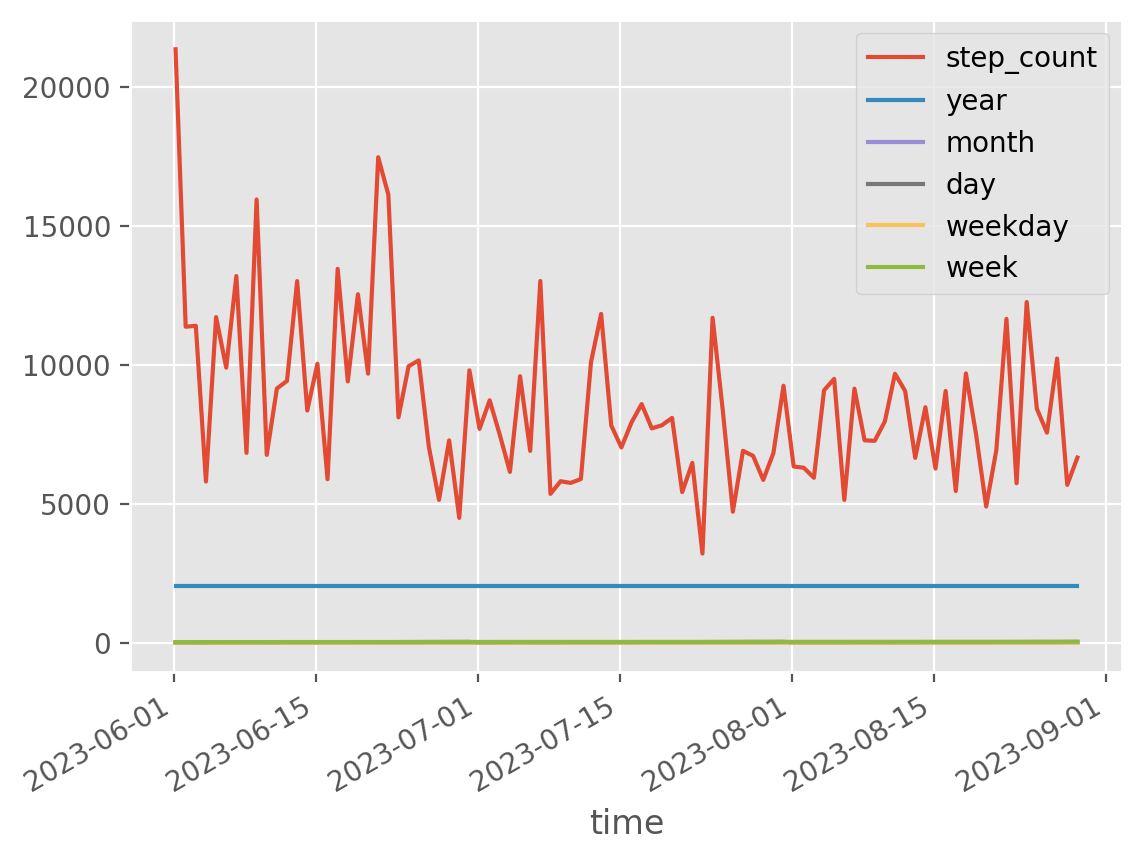

In [ ]:
df.plot()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.style as style
import missingno as msno

print(f"Data Available from {df.index.min()} to {df.index.max()}")

df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekdayName'] = df.index.day_name()
df['weekday'] = df.index.weekday
df['week'] = df.index.isocalendar().week
df['weekend'] = df.index.weekday // 5 == 1

all_month_year_df = pd.pivot_table(
    df,
    values=['step_count'],
    index=['weekday'],
    columns=['month'],
    fill_value=None,
    aggfunc={'step_count': [np.average]}
)

named_index = [[calendar.day_abbr[i] if isinstance(i, int) else i for i in list(all_month_year_df.index)]]
all_month_year_df = all_month_year_df.set_index(named_index)

# without this, we get an error when trying to generate a heatmap
all_month_year_df = all_month_year_df[all_month_year_df.columns].astype(float)

all_month_year_df

Data Available from 2023-06-01 04:00:00+00:00 to 2023-08-29 04:00:00+00:00
         step_count                          
            average                          
month             6            7            8
Mon    10174.886695  8547.030353  7548.279522
Tue     9427.523198  7028.285302  7636.655357
Wed    11568.431986  8051.723195  7086.314385
Thu    11761.691170  8427.465293  7898.617493
Fri    10216.619882  8239.706412  9211.995839
Sat    10384.982398  6476.927367  8399.095034
Sun     8622.404932  6494.667361  6725.216194


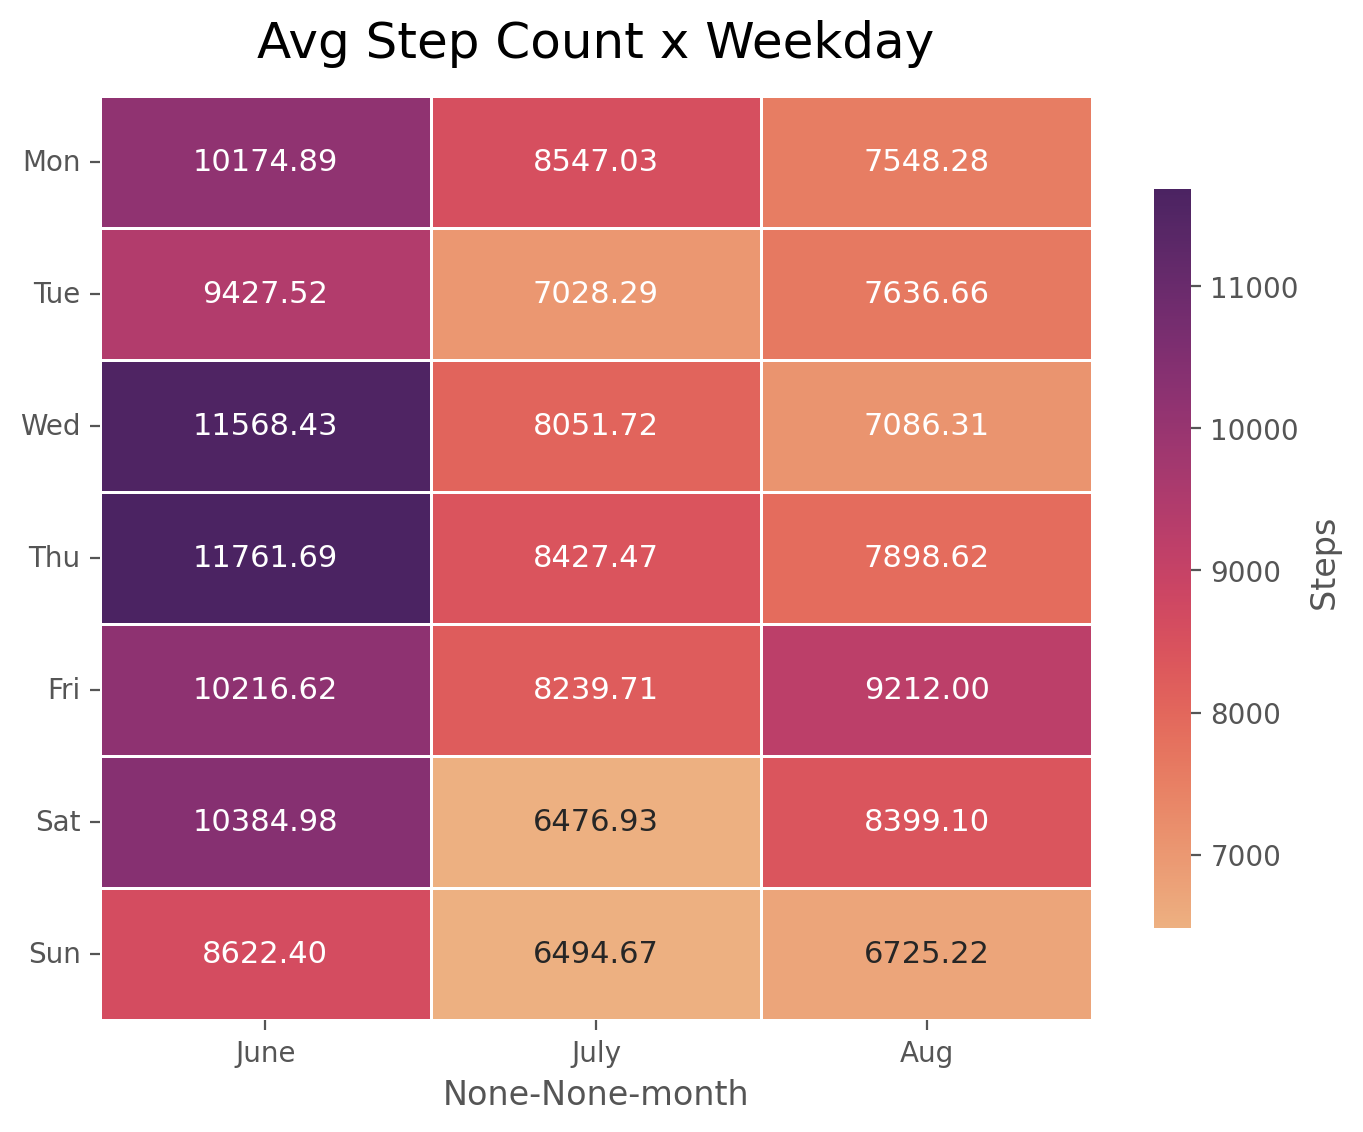

In [ ]:
import matplotlib as mpl

def plot_heatmap(df, title):
    plt.figure(figsize = (8, 6))

    sns.color_palette("rocket", as_cmap=True)
    ax = sns.heatmap(df,
                     cmap="flare",
                     robust=True,
                     fmt='.2f', annot=True,
                     linewidths=.5, annot_kws={'size':11},
                     cbar_kws={'shrink':.8, 'label':'Steps '})

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)

    plt.title(title, fontdict={'fontsize':18}, pad=14);

# TODO: figure out how to rename multiindex columns the right way
all_month_year_df.columns.values[0] = ["June"]
all_month_year_df.columns.values[1] = ["July"]
all_month_year_df.columns.values[2] = ["Aug"]

plot_heatmap(all_month_year_df, 'Avg Step Count x Weekday')

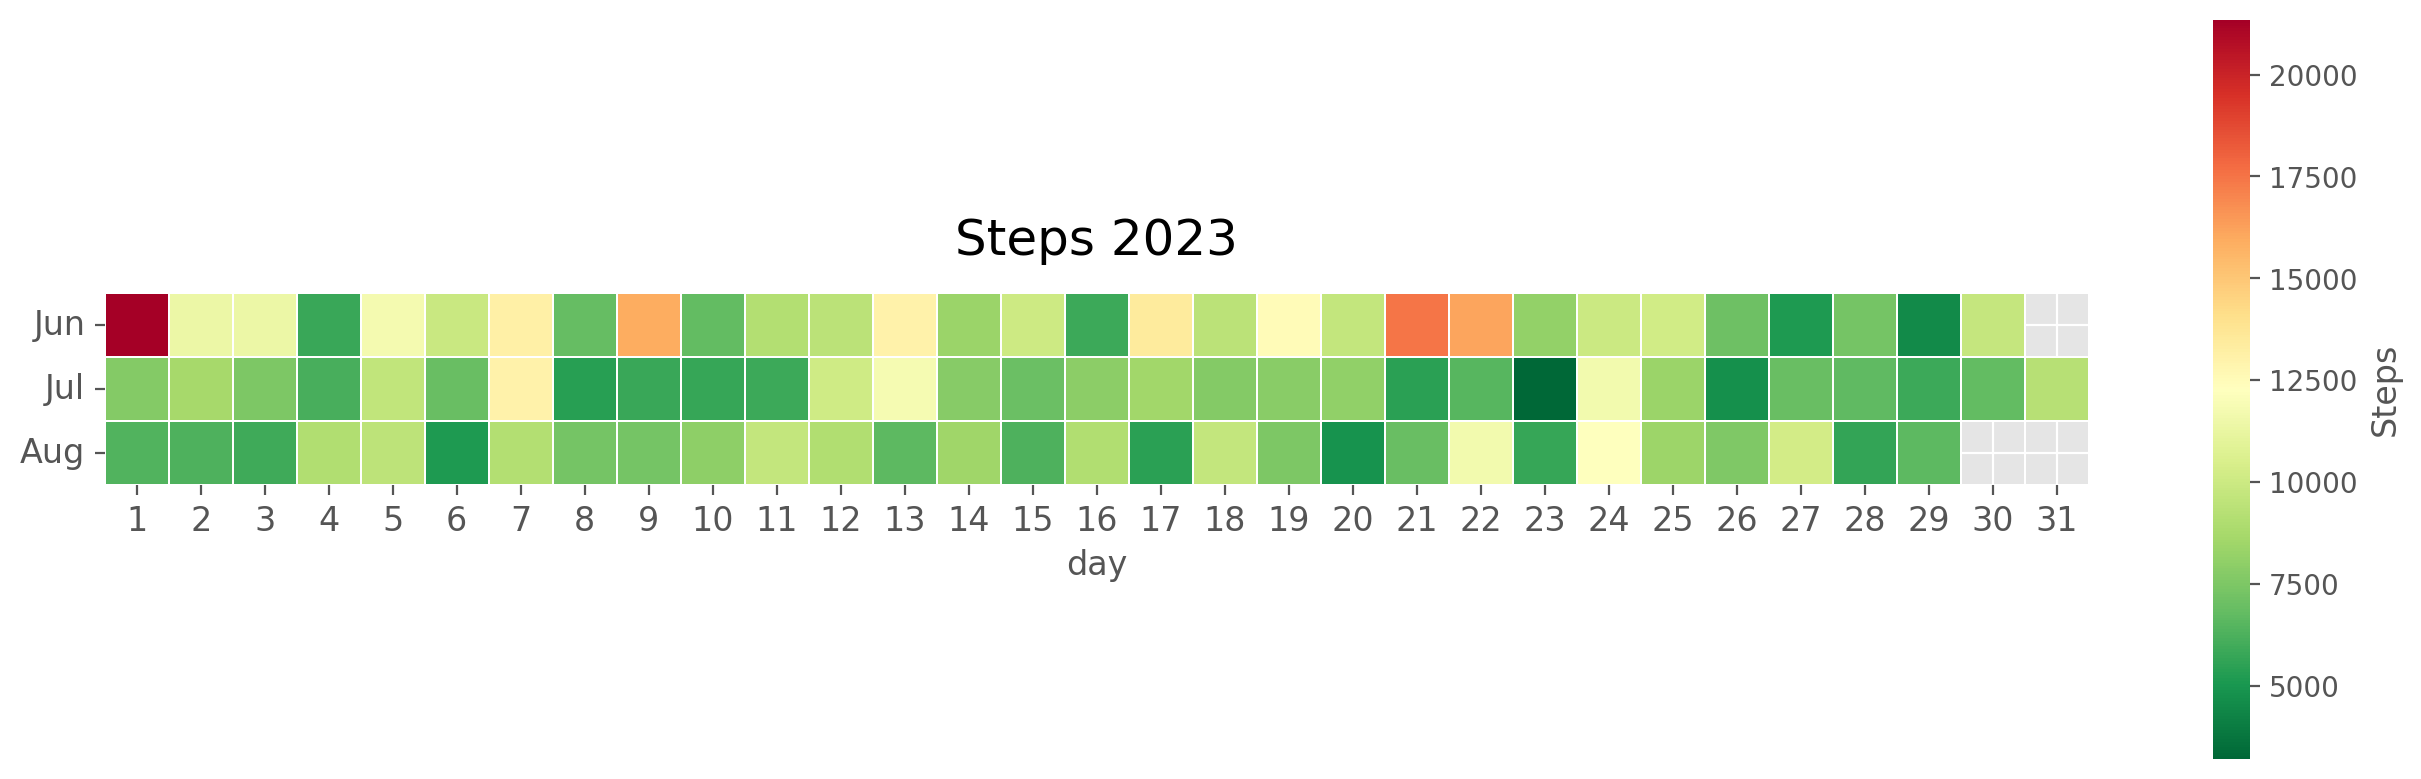

In [ ]:

def plot_heatmap_year(year):
    plt.figure(figsize = (16, 10))
    allByYear_df = df.loc[df['year'] == year]
    allByYear_df = pd.pivot_table(allByYear_df, values="step_count",
                                  index=["month"], columns=["day"], fill_value=None)
    allByYear_df = allByYear_df[allByYear_df.columns].astype(float)
    allByYear_df = allByYear_df.set_index([[calendar.month_abbr[i] for i in list(allByYear_df.index)]])
    ax = sns.heatmap(allByYear_df, cmap = 'RdYlGn_r',
                     annot=False, linewidths=.1,
                     annot_kws={"size": 8}, square=True, cbar_kws={"shrink": .48, 'label': 'Steps'})
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
    ax.tick_params(rotation = 0)
    plt.title(f'Steps {year}', fontdict={'fontsize':18}, pad=14);

plot_heatmap_year(2023)

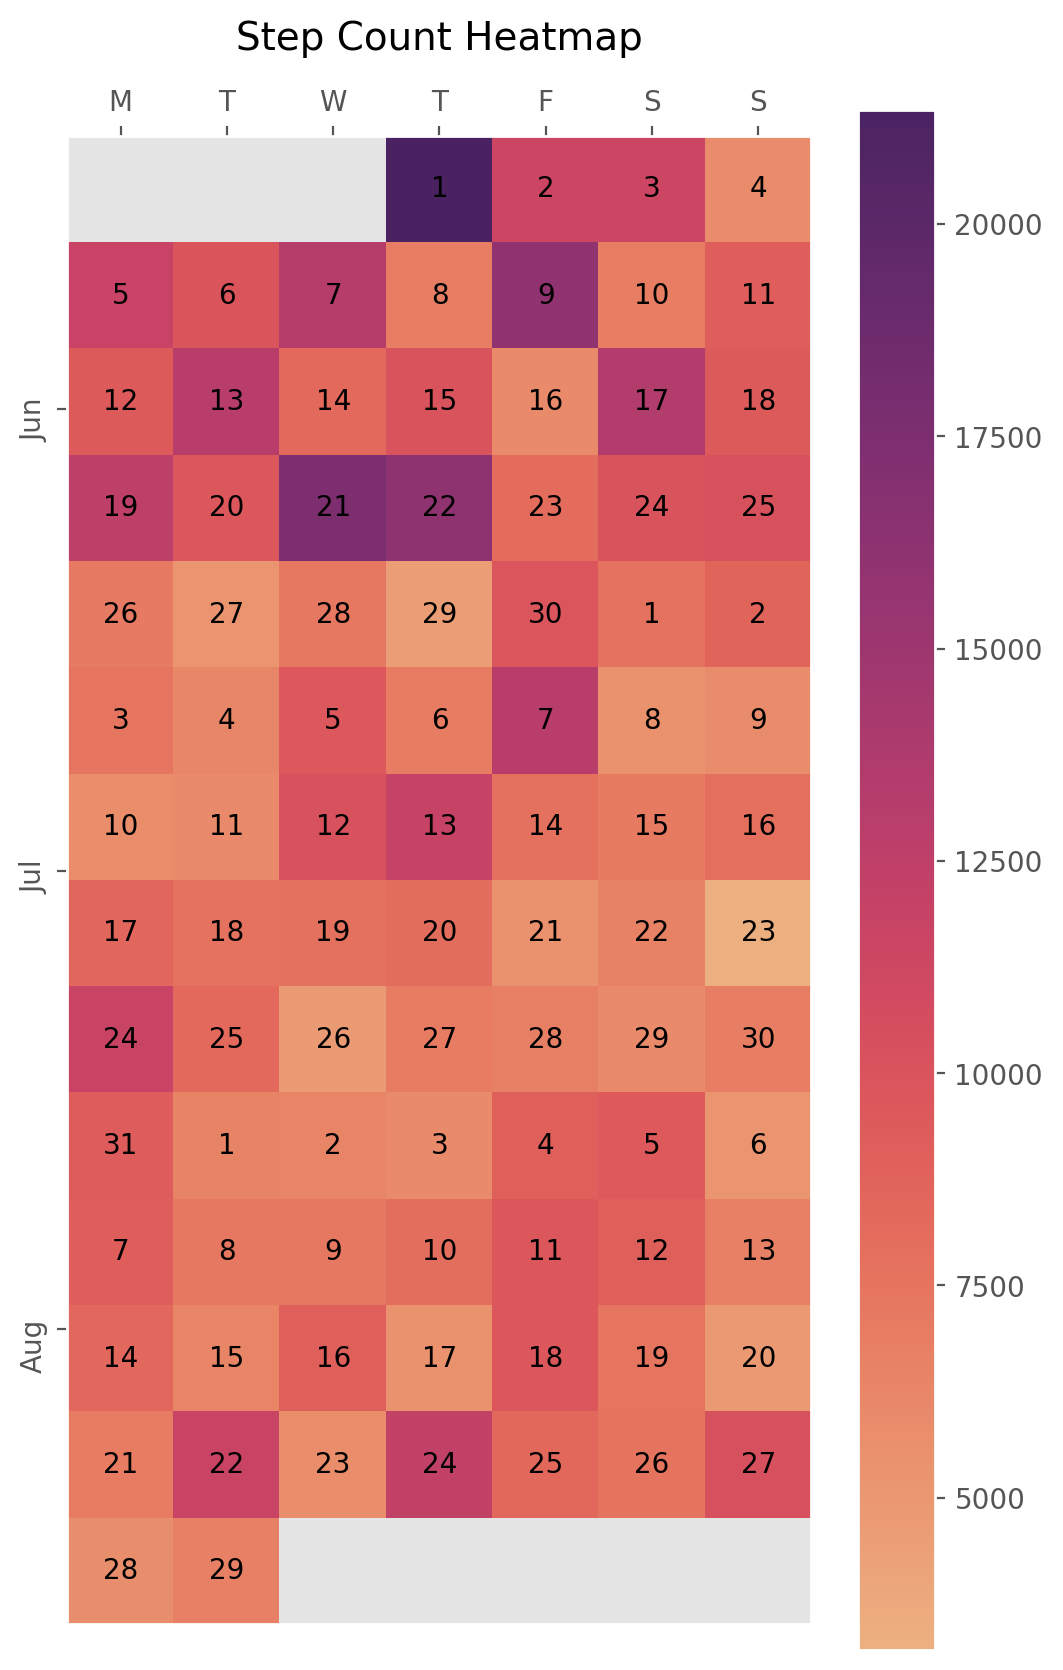

In [ ]:
import datetime as dt

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar

def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='flare')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7),
           xticklabels=['M', 'T', 'W', 'T', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

step_dates = [pd.to_datetime(i) for i in df.index.values]

fig, ax = plt.subplots(figsize=(6, 10))
ax.grid(False)

calendar_heatmap(ax, step_dates, df.step_count.values)

plt.title('Step Count Calendar Heatmap', fontdict={'fontsize':14}, pad=14);
plt.show()